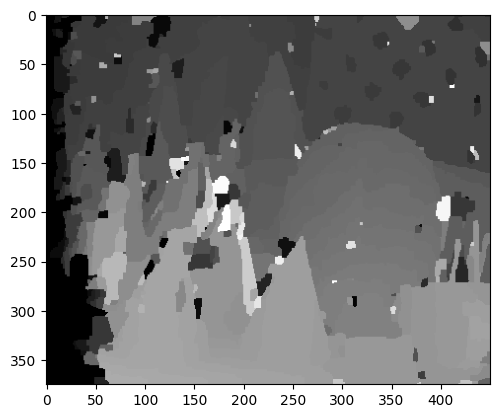

In [4]:
import gco
import skimage.io as io
import numpy as np
import cv2
import matplotlib.pyplot as plt
import math

img1 = cv2.imread('im2.png')
img2 = cv2.imread('im6.png')
[H, W] = img1.shape[0:2]

# select image order
imgR = cv2.cvtColor(img1,cv2.COLOR_RGB2GRAY)
imgL = cv2.cvtColor(img2,cv2.COLOR_RGB2GRAY)
# imgR: in which objects are on the right in general.
# imgL: in which objects are on the left in general.

# set parameters (class and labelcost)
# regularization of prior term 
Lambda = 0.04
no_disparity = 80
# set disparity range: disparity = d_min:d_max
disparity = list(range(0, no_disparity,1))

# Change d_max only. This should be less than image width.

# set class
m_class = np.ones([1, H*W])

# set labelcost (prior term)
[a, b] = np.meshgrid(disparity,disparity)


labelcost = (a - b) # log distance
smooth = (1 - np.eye(no_disparity)) *Lambda
# labelcost = abs(a - b); % Euclidean distance (L2)
# This can also be done using function pdist2.

## calculate (pixel-wise) disparity
unary = np.zeros([H, W, no_disparity])

for d in disparity:
    # fetch the left part of imgL
    imgL_left = imgL[:, 0:W-d]
    
    # fetch the right part of imgR
    imgR_right = imgR[:, d:W]
    
    # calculate the distance
    # dist = sum(abs(imgL_left - imgR_right), 3); % L1 distance
    dist = np.sqrt(((imgL_left - imgR_right)^2)) # L2 distance
    
    # padding with maximum depth when there is no value to compare
    # max_depth = 255 * 3;  % L1 distance
    max_depth = np.sqrt(255)   #np.sqrt(255 ^ 2 * 3)  # L2 distance

    dist_filled = np.zeros([H,W])
    dist_filled[0:H,0:d] = np.array([np.ones([H, d]) * max_depth])
    dist_filled[0:H,d:W] = dist

    unary[:,:, d] = dist_filled


## set parameters (unary and pairwise)
# run graph cut
labels = gco.cut_grid_graph_simple(unary/255, smooth, n_iter=-1)
new_image = np.reshape(labels, imgR.shape).astype(int)

plt.figure(1)
plt.imshow(new_image.astype(int),cmap='gray')


<font face = "Time New Roman" size = 5> The result is not so ideal. The left black block is the effection of filling outliers. There are some noise in the picture, I have tried to change lambda and disparity to enhance the result but I can't get a very ideal result in this way.

<font face = "Time New Roman" size = 5>As an exploration, I tried to use Belief-Propagation alogrism to get the dimension. The result is a little bit better than MRF.

In [7]:
import gco
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
import warnings

def stereoLBP(img_l, img_r, k=50, s=0.05, eta=1, iterations=20):
    H, W, C = img_l.shape
    D = np.zeros((H, W, k))
    for i in range(k):
        tmp = np.zeros((H, W, C))
        tmp[:, :W - i, :] = img_l[:, i:, :]
        D[:, :, i] = np.sum((img_r - tmp) ** 2, -1) ** 0.5
    D = D / np.max(D)

    AFFINE_DIR = {'up': np.array([[1, 0, 0], [0, 1, -1]], dtype=np.float32),
                  'down': np.array([[1, 0, 0], [0, 1, 1]], dtype=np.float32),
                  'left': np.array([[1, 0, -1], [0, 1, 0]], dtype=np.float32),
                  'right': np.array([[1, 0, 1], [0, 1, 0]], dtype=np.float32)}
    m = {'up':      np.zeros((H, W, k)),
         'down':    np.zeros((H, W, k)),
         'left':    np.zeros((H, W, k)),
         'right':   np.zeros((H, W, k))}
    h = {'up':      np.zeros((H, W, k)),
         'down':    np.zeros((H, W, k)),
         'left':    np.zeros((H, W, k)),
         'right':   np.zeros((H, W, k))}
    for _ in range(iterations):
        h_tot = D + m['up'] + m['down'] + m['left'] + m['right']
        h['up'] = cv.warpAffine(h_tot-m['down'], AFFINE_DIR['down'], dsize=(W, H))
        h['down'] = cv.warpAffine(h_tot-m['up'], AFFINE_DIR['up'], dsize=(W, H))
        h['left'] = cv.warpAffine(h_tot-m['right'], AFFINE_DIR['right'], dsize=(W, H))
        h['right'] = cv.warpAffine(h_tot-m['left'], AFFINE_DIR['left'], dsize=(W, H))
        for x in {'up', 'down', 'left', 'right'}:
            m[x] = h[x]
            for i in range(1, k):
                m[x][:, :, i] = np.minimum(m[x][:, :, i], m[x][:, :, i-1] +  s)
            for i in reversed(range(0, k-1)):
                m[x][:, :, i] = np.minimum(m[x][:, :, i], m[x][:, :, i+1] + s)

        for x in {'up', 'down', 'left', 'right'}:
            tmp = h[x].min(axis=-1, keepdims=True) + eta
            m[x] = np.minimum(m[x], tmp)
    B = np.copy(D)
    for x in {'up', 'down', 'left', 'right'}:
        B = B + m[x]
    tmp =  np.argmin(B, -1)
    res = tmp / np.max(tmp)
    return res

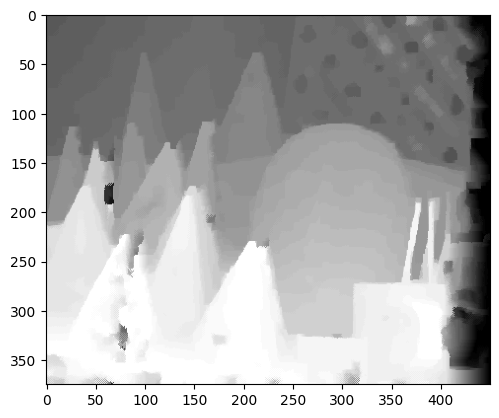

In [8]:
if __name__ == '__main__':
    img1 = cv.imread('im2.png')
    img2 = cv.imread('im6.png')
    disp = stereoLBP(img1, img2)
    plt.figure(0)
    plt.imshow( disp,cmap='gray')